In [1]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

Using TensorFlow backend.


In [2]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 2s 0us/step


In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
def space_to_depth_x2(x):
    return tf.space_to_depth(x, block_size=2)

In [0]:
img_height, img_width, channel = train_features.shape[1],train_features.shape[2],train_features.shape[3]

In [8]:
train_features.shape[3]

3

In [0]:
from keras.layers import Input
input = Input(shape=(img_height, img_width, channel))

In [10]:
input

<tf.Tensor 'input_1:0' shape=(?, 32, 32, 3) dtype=float32>

In [0]:
input1=Input(shape=(32,32,3))

In [12]:
input1

<tf.Tensor 'input_2:0' shape=(?, 32, 32, 3) dtype=float32>

In [13]:
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization,SeparableConv2D
from keras.layers import concatenate

#normal convolutions
layer1 = Conv2D(32, (3,3), strides=(1,1), padding='same', name='conv_1', use_bias=False,dilation_rate = 1)(input)
layer1 = Dropout(0.2)(layer1)
layer1 = BatchNormalization(name='norm_1')(layer1)
layer1 = Activation('relu')(layer1)

#spatially seperable convolutions
layer2 = Conv2D(64,(3,1), strides=(1,1), padding = 'same',name= 'Spatial_seperable1',use_bias=False)(layer1)
layer2 = Conv2D(64,(1,3), strides=(1,1), padding = 'same',name= 'Spatial_seperable2',use_bias=False)(layer2)
layer2 = Dropout(0.2)(layer2)
layer2 = BatchNormalization(name='norm_3')(layer2)
layer2 = Activation('relu')(layer2)

#depthwise seprable convolutions
layer3 = SeparableConv2D(128,(3,3), strides=(1,1), padding = 'same',name= 'depthwise',use_bias=False)(layer2)
layer3 = Dropout(0.2)(layer3)
layer3 = BatchNormalization(name='norm_2')(layer3)
layer3 = Activation('relu')(layer3)

layer3=Conv2D(64, (1,1),padding='same',use_bias=False)(layer3)

#normal convolution with dilation rate 1 , using for grouped convolution
layer4 = Conv2D(64,(3,3), strides=(1,1), padding = 'same',name= 'grouped_conv1',use_bias=False,dilation_rate=1)(layer3)
layer4 = Dropout(0.2)(layer4)
layer4 = BatchNormalization(name='norm_4')(layer4)
layer4 = Activation('relu')(layer4)

layer5 = Conv2D(64,(5,5), strides=(1,1), padding = 'same',name= 'grouped_conv2',use_bias=False,dilation_rate=1)(layer3)
layer5 = Dropout(0.2)(layer5)
layer5 = BatchNormalization(name='norm_5')(layer5)
layer5 = Activation('relu')(layer5)

#grouped convolution with dilation rate 1
layer6= concatenate([layer4, layer5])

#Transition block
layer7 = MaxPooling2D(pool_size=(2, 2))(layer6)
layer7 = Conv2D(32, (1,1),padding='same',use_bias=False)(layer7)

#normal convolution with dilation rate 2 , using for grouped convolution
layer8 =Conv2D(32, (3,3), strides=(1,1), padding='same', name='grouped_conv3', use_bias=False,dilation_rate = 1)(layer7)
layer8 = Dropout(0.2)(layer8)
layer8 = BatchNormalization(name='norm_6')(layer8)
layer8 = Activation('relu')(layer8)

layer9 = Conv2D(64,(3,3), strides=(1,1), padding = 'same',name= 'grouped_conv4',use_bias=False,dilation_rate=2)(layer7)
layer9 = Dropout(0.2)(layer9)
layer9 = BatchNormalization(name='norm_7')(layer9)
layer9 = Activation('relu')(layer9)

#grouped convolution with dilation rate 2
layer10= concatenate([layer8, layer9])

layer11 = Conv2D(96,(3,3), strides=(1,1),name= 'conv_2',use_bias=False)(layer10)
layer11 = BatchNormalization(name='norm_8')(layer11)
layer11 = Activation('relu')(layer11)

layer12 = MaxPooling2D(pool_size=(2, 2))(layer11)
layer12 = Conv2D(32, (1,1),use_bias=False)(layer12)

layer13 = Conv2D(32,(3,3), strides=(1,1),name= 'conv_3',use_bias=False)(layer12)
layer13 = BatchNormalization(name='norm_9')(layer13)
layer13 = Activation('relu')(layer13)

layer14 = Conv2D(10, (1,1),padding='same',use_bias=False)(layer13)
layer14 = Conv2D(10,5)(layer14)


layer15 = Flatten()(layer14)
output=Activation('softmax')(layer15)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [14]:
from keras.models import Model
model = Model(inputs=[input], outputs=[output])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 32, 32, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 32, 32, 32)   0           conv_1[0][0]                     
__________________________________________________________________________________________________
norm_1 (BatchNormalization)     (None, 32, 32, 32)   128         dropout_1[0][0]                  
__________________________________________________________________________________________________
activation

In [0]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=50)`
  if sys.path[0] == '':


Epoch 1/50
390/390 [==============================] - 43s 111ms/step - loss: 1.4430 - acc: 0.4760 - val_loss: 2.8612 - val_acc: 0.2910
Epoch 2/50
390/390 [==============================] - 39s 99ms/step - loss: 1.0141 - acc: 0.6382 - val_loss: 1.1504 - val_acc: 0.5998
Epoch 3/50
390/390 [==============================] - 37s 96ms/step - loss: 0.8286 - acc: 0.7093 - val_loss: 0.9636 - val_acc: 0.6760
Epoch 4/50
390/390 [==============================] - 37s 96ms/step - loss: 0.7264 - acc: 0.7457 - val_loss: 0.8725 - val_acc: 0.7062
Epoch 5/50
390/390 [==============================] - 37s 96ms/step - loss: 0.6496 - acc: 0.7703 - val_loss: 0.7616 - val_acc: 0.7496
Epoch 6/50
390/390 [==============================] - 37s 96ms/step - loss: 0.5973 - acc: 0.7912 - val_loss: 0.9011 - val_acc: 0.7244
Epoch 7/50
390/390 [==============================] - 37s 96ms/step - loss: 0.5480 - acc: 0.8103 - val_loss: 0.8921 - val_acc: 0.7300
Epoch 8/50
390/390 [==============================] - 38s 96m

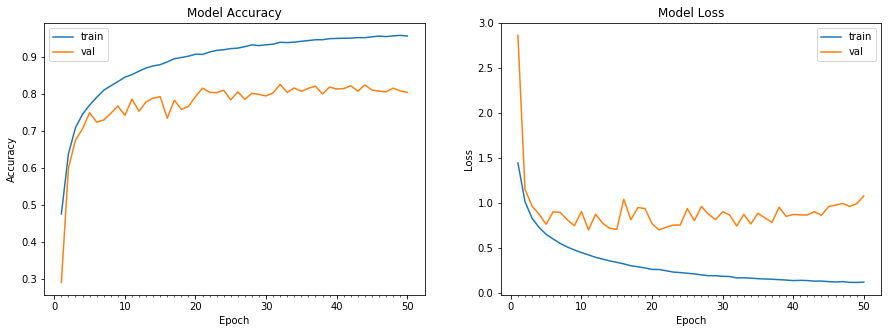

Accuracy on test data is: 80.46


In [16]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 50, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))